Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 20%|██        | 10/49 [00:05<00:20,  1.86it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
9/9 ━━━━━━━━━━━━━━━━━━━━ 307s 29s/step - AUC: 0.8607 - loss: 0.4519 - val_AUC: 1.0000 - val_loss: 0.8878
Epoch 2/2
9/9 ━━━━━━━━━━━━━━━━━━━━ 317s 29s/step - AUC: 0.9998 - loss: 0.0976 - val_AUC: 1.0000 - val_loss: 1.0809
Epoch 1/2
9/9 ━━━━━━━━━━━━━━━━━━━━ 86s 8s/step - AUC: 0.5441 - loss: 1.0662 - val_AUC: 0.8500 - val_loss: 0.6604
Epoch 2/2
9/9 ━━━━━━━━━━━━━━━━━━━━ 80s 8s/step - AUC: 0.9047 - loss: 0.6158 - val_AUC: 0.6000 - val_loss: 0.8422
Epoch 1/2
9/9 ━━━━━━━━━━━━━━━━━━━━ 160s 10s/step - AUC: 0.9111 - loss: 0.5095 - val_AUC: 0.5000 - val_loss: 0.7261
Epoch 2/2
9/9 ━━━━━━━━━━━━━━━━━━━━ 86s 9s/step - AUC: 0.9995 - loss: 0.1466 - val_AUC: 0.5000 - val_loss: 0.7564
Epoch 1/2
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - AUC: 0.5588 - loss: 0.9801 - val_AUC: 0.8600 - val_loss: 0.6787
Epoch 2/2
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - AUC: 0.9813 - loss: 0.1845 - val_AUC: 0.8600 - val_loss: 0.6427
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
Frame-level AUC -

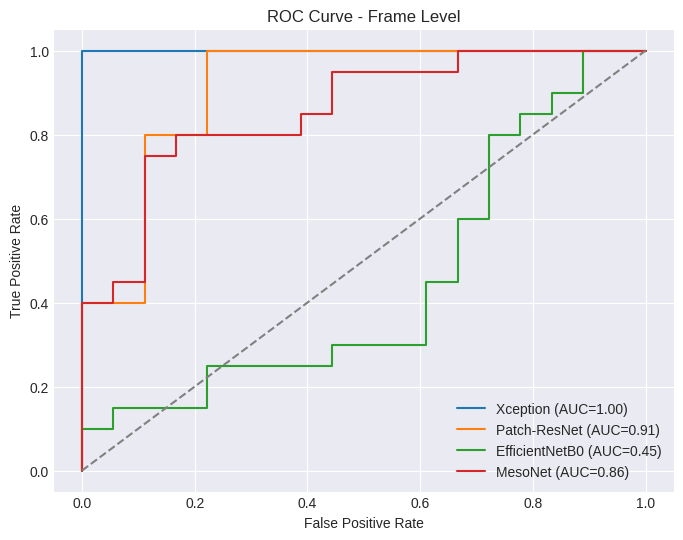

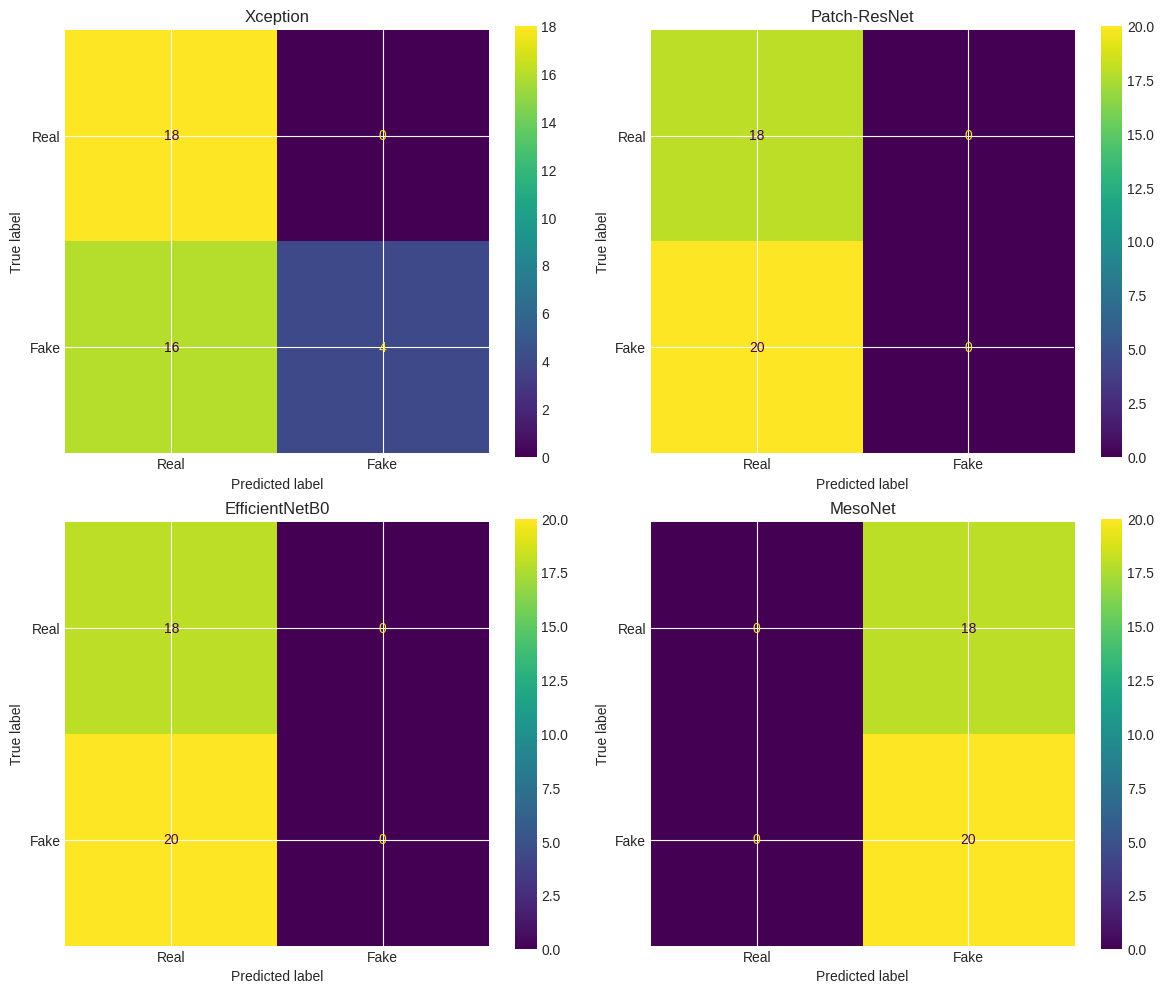

Xception params: 20863529
Patch-ResNet params: 230017
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
Xception time: 759.0653896331787 ms
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Patch-ResNet time: 323.4391212463379 ms
EfficientNetB0 params: 4050852
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
EfficientNetB0 time: 380.30242919921875 ms
MesoNet params: 75145
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


MesoNet time: 128.40890884399414 ms


In [7]:
# SECTION 1: Setup and Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Flatten, Dropout
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.applications import Xception, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.optimizers import Adam
import time

# Set paths
REAL_PATH = '/content/drive/MyDrive/EE656/real'
FAKE_PATH = '/content/drive/MyDrive/EE656/fake'

# SECTION 2: Frame Extraction and Preprocessing (with Haar face detection)
def extract_faces_from_video(video_path, max_frames=10):  # reduced for memory efficiency
    faces = []
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    while cap.isOpened() and frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces_rect = face_cascade.detectMultiScale(gray, 1.3, 5)
        for (x, y, w, h) in faces_rect:
            face = frame[y:y+h, x:x+w]
            face = cv2.resize(face, (299, 299))
            faces.append(face)
            break  # only one face per frame
        frame_count += 1
    cap.release()
    return faces

# Load real and fake frames (limit dataset size for memory)
def load_dataset(max_videos_per_class=10):
    X, y, vids = [], [], []
    for label, folder in enumerate([REAL_PATH, FAKE_PATH]):
        for i, filename in enumerate(tqdm(os.listdir(folder))):
            if filename.endswith('.mp4'):
                if i >= max_videos_per_class:
                    break
                video_path = os.path.join(folder, filename)
                faces = extract_faces_from_video(video_path)
                for face in faces:
                    X.append(face / 255.0)
                    y.append(label)
                    vids.append(filename)
    return np.array(X), np.array(y), np.array(vids)

X, y, vids = load_dataset()

# SECTION 3: Train/Test Split
X_train, X_test, y_train, y_test, vids_train, vids_test = train_test_split(X, y, vids, test_size=0.2, stratify=y, random_state=42)
#Resize for MesoNet
X_train_m = np.array([cv2.resize((img*255).astype(np.uint8), (256,256))/255.0 for img in X_train])
X_test_m  = np.array([cv2.resize((img*255).astype(np.uint8), (256,256))/255.0 for img in X_test])

# SECTION 4: Build Models
# Xception
inp = Input(shape=(299, 299, 3))
xception = Xception(include_top=False, weights='imagenet', input_tensor=inp)
x = GlobalAveragePooling2D()(xception.output)
x = Dense(1, activation='sigmoid')(x)
model_x = Model(inputs=inp, outputs=x)
model_x.compile(optimizer=Adam(learning_rate=2e-4), loss='binary_crossentropy', metrics=['AUC'])

# Patch-ResNet (Layer1)
inp2 = Input(shape=(299, 299, 3))
resnet = ResNet50(include_top=False, weights='imagenet', input_tensor=inp2)
res_layer1 = resnet.get_layer('conv2_block3_out').output
y = GlobalAveragePooling2D()(res_layer1)
y = Dense(1, activation='sigmoid')(y)
model_r = Model(inputs=inp2, outputs=y)
model_r.compile(optimizer=Adam(learning_rate=2e-4), loss='binary_crossentropy', metrics=['AUC'])

# --- EfficientNetB0 ---
inp3 = Input(shape=(299, 299, 3))
effnet = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=inp3)
e = GlobalAveragePooling2D()(effnet.output)
e = Dense(1, activation='sigmoid')(e)
model_e = Model(inputs=inp3, outputs=e)
model_e.compile(optimizer=Adam(learning_rate=2e-4),
                loss='binary_crossentropy', metrics=['AUC'])

# --- MesoNet (256×256 input) ---
def build_mesonet(input_shape=(256,256,3)):
    m = Sequential()
    m.add(Conv2D(8, (3, 3), padding='same', input_shape=input_shape))
    m.add(BatchNormalization()); m.add(Activation('relu'))
    m.add(Conv2D(8, (5, 5), strides=2, padding='same'))
    m.add(BatchNormalization()); m.add(Activation('relu'))
    m.add(Conv2D(16, (3, 3), padding='same'))
    m.add(BatchNormalization()); m.add(Activation('relu'))
    m.add(Conv2D(16, (5, 5), strides=2, padding='same'))
    m.add(BatchNormalization()); m.add(Activation('relu'))
    m.add(Flatten())
    m.add(Dropout(0.5))
    m.add(Dense(1, activation='sigmoid'))
    m.compile(optimizer=Adam(learning_rate=2e-4),
              loss='binary_crossentropy', metrics=['AUC'])
    return m

# Instantiate MesoNet
model_meso = build_mesonet()

# SECTION 5: Training (reduce batch size and epochs)
model_x.fit(X_train, y_train, epochs=2, batch_size=16, validation_split=0.1)
model_r.fit(X_train, y_train, epochs=2, batch_size=16, validation_split=0.1)
model_e.fit(X_train,   y_train, epochs=2, batch_size=16, validation_split=0.1)
model_meso.fit(X_train_m, y_train, epochs=2, batch_size=16, validation_split=0.1)

# SECTION 6: Evaluation
pred_x = model_x.predict(X_test)
pred_r = model_r.predict(X_test)
auc_frame_x = roc_auc_score(y_test, pred_x)
auc_frame_r = roc_auc_score(y_test, pred_r)
print("Frame-level AUC - Xception:", auc_frame_x)
print("Frame-level AUC - Patch-ResNet:", auc_frame_r)
# SECTION 6.1: Evaluate EfficientNetB0
pred_e = model_e.predict(X_test).flatten()
auc_e = roc_auc_score(y_test, pred_e)
acc_e = accuracy_score(y_test, (pred_e>0.5).astype(int))
print("Frame-level AUC - EfficientNetB0:", auc_e)
print("Frame-level Accuracy - EfficientNetB0:", acc_e)

# SECTION 6.2: Evaluate MesoNet
pred_meso = model_meso.predict(X_test_m).flatten()
auc_m = roc_auc_score(y_test, pred_meso)
acc_m = accuracy_score(y_test, (pred_meso>0.5).astype(int))
print("Frame-level AUC - MesoNet:", auc_m)
print("Frame-level Accuracy - MesoNet:", acc_m)

# Video-level AUC
video_df = pd.DataFrame({
    'video': vids_test,
    'label': y_test,
    'pred_x': pred_x.flatten(),
    'pred_r': pred_r.flatten()
})
vid_preds_x = video_df.groupby('video')['pred_x'].mean()
vid_labels = video_df.groupby('video')['label'].first()
vid_preds_r = video_df.groupby('video')['pred_r'].mean()
auc_vid_x = roc_auc_score(vid_labels, vid_preds_x)
auc_vid_r = roc_auc_score(vid_labels, vid_preds_r)
print("Video-level AUC - Xception:", auc_vid_x)
print("Video-level AUC - Patch-ResNet:", auc_vid_r)




# for visuals
from sklearn.metrics import roc_curve

# Compute ROC curves
fpr_x, tpr_x, _ = roc_curve(y_test, pred_x)
fpr_r, tpr_r, _ = roc_curve(y_test, pred_r)
fpr_e, tpr_e, _ = roc_curve(y_test, pred_e)
fpr_m, tpr_m, _ = roc_curve(y_test, pred_meso)

plt.figure(figsize=(8, 6))
plt.plot(fpr_x, tpr_x, label=f"Xception (AUC={auc_frame_x:.2f})")
plt.plot(fpr_r, tpr_r, label=f"Patch-ResNet (AUC={auc_frame_r:.2f})")
plt.plot(fpr_e, tpr_e, label=f"EfficientNetB0 (AUC={auc_e:.2f})")
plt.plot(fpr_m, tpr_m, label=f"MesoNet (AUC={auc_m:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Frame Level")
plt.legend()
plt.grid(True)
plt.show()

from sklearn.metrics import accuracy_score

# Convert probabilities to binary predictions
bin_pred_x = (pred_x > 0.5).astype(int)
bin_pred_r = (pred_r > 0.5).astype(int)
bin_pred_e = (pred_e > 0.5).astype(int)
bin_pred_m = (pred_meso > 0.5).astype(int)


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Binary predictions
models_preds = {
    "Xception": bin_pred_x,
    "Patch-ResNet": bin_pred_r,
    "EfficientNetB0": bin_pred_e,
    "MesoNet": bin_pred_m
}

plt.figure(figsize=(12, 10))
for i, (name, pred_bin) in enumerate(models_preds.items()):
    cm = confusion_matrix(y_test, pred_bin)
    ax = plt.subplot(2, 2, i + 1)
    ConfusionMatrixDisplay(cm, display_labels=["Real", "Fake"]).plot(ax=ax, values_format='d')
    plt.title(name)
plt.tight_layout()
plt.show()




# SECTION 7: Params and Inference Time
print("Xception params:", model_x.count_params())
print("Patch-ResNet params:", model_r.count_params())

start = time.time()
_ = model_x.predict(np.expand_dims(X_test[0], axis=0))
print("Xception time:", (time.time() - start) * 1000, "ms")

start = time.time()
_ = model_r.predict(np.expand_dims(X_test[0], axis=0))
print("Patch-ResNet time:", (time.time() - start) * 1000, "ms")

# SECTION 7.1: Params & Inference Time
print("EfficientNetB0 params:", model_e.count_params())
start = time.time(); _ = model_e.predict(np.expand_dims(X_test[0],axis=0))
print("EfficientNetB0 time:", (time.time()-start)*1000, "ms")

print("MesoNet params:", model_meso.count_params())
start = time.time(); _ = model_meso.predict(np.expand_dims(X_test_m[0],axis=0))
print("MesoNet time:", (time.time()-start)*1000, "ms")

# SECTION 8: Save Model and Results
model_x.save('/content/drive/MyDrive/xception_model.h5')
model_r.save('/content/drive/MyDrive/patchresnet_model.h5')

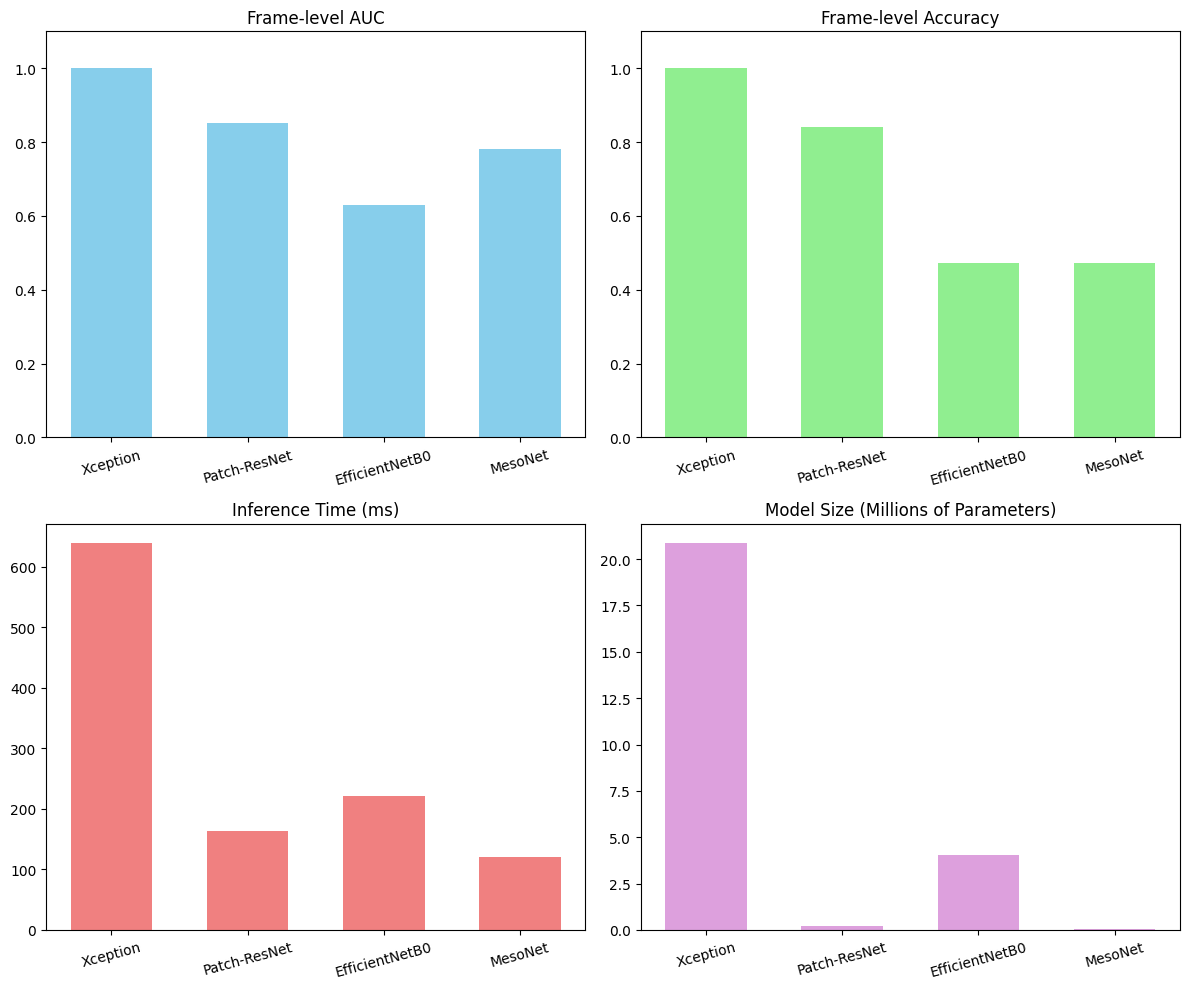

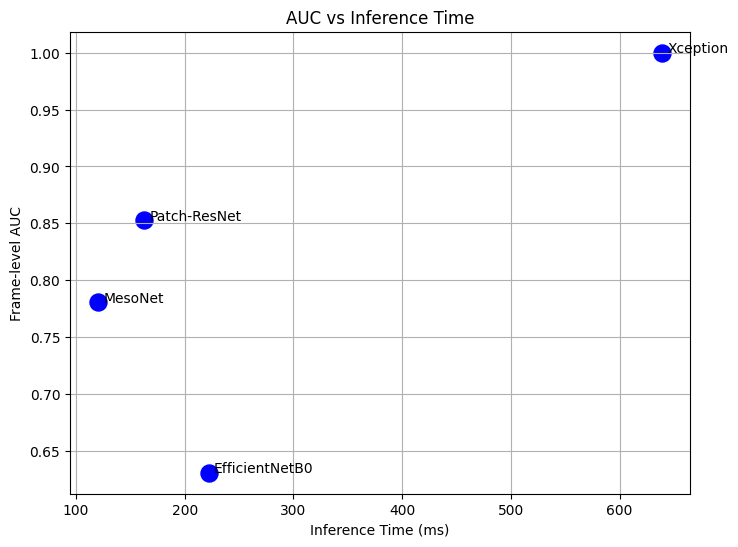

In [5]:
import matplotlib.pyplot as plt

# Metric values from your run (update if needed)
model_names = ["Xception", "Patch-ResNet", "EfficientNetB0", "MesoNet"]
frame_auc = [1.0, 0.8528, 0.6306, 0.7806]
accuracy = [1.0, 0.8421, 0.4737, 0.4737]
inference_time = [638.84, 162.89, 221.93, 120.46]  # in ms
params = [20.86, 0.23, 4.05, 0.075]  # in millions

# Plot configuration
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
bar_width = 0.6
x = range(len(model_names))

# Frame-level AUC
axes[0, 0].bar(x, frame_auc, color='skyblue', width=bar_width)
axes[0, 0].set_title("Frame-level AUC")
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(model_names, rotation=15)
axes[0, 0].set_ylim(0, 1.1)

# Accuracy
axes[0, 1].bar(x, accuracy, color='lightgreen', width=bar_width)
axes[0, 1].set_title("Frame-level Accuracy")
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(model_names, rotation=15)
axes[0, 1].set_ylim(0, 1.1)

# Inference Time
axes[1, 0].bar(x, inference_time, color='lightcoral', width=bar_width)
axes[1, 0].set_title("Inference Time (ms)")
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(model_names, rotation=15)

# Parameter Count
axes[1, 1].bar(x, params, color='plum', width=bar_width)
axes[1, 1].set_title("Model Size (Millions of Parameters)")
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(model_names, rotation=15)

plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(inference_time, frame_auc, c='blue', s=150)

for i, name in enumerate(model_names):
    plt.text(inference_time[i] + 5, frame_auc[i], name)

plt.xlabel("Inference Time (ms)")
plt.ylabel("Frame-level AUC")
plt.title("AUC vs Inference Time")
plt.grid(True)
plt.show()



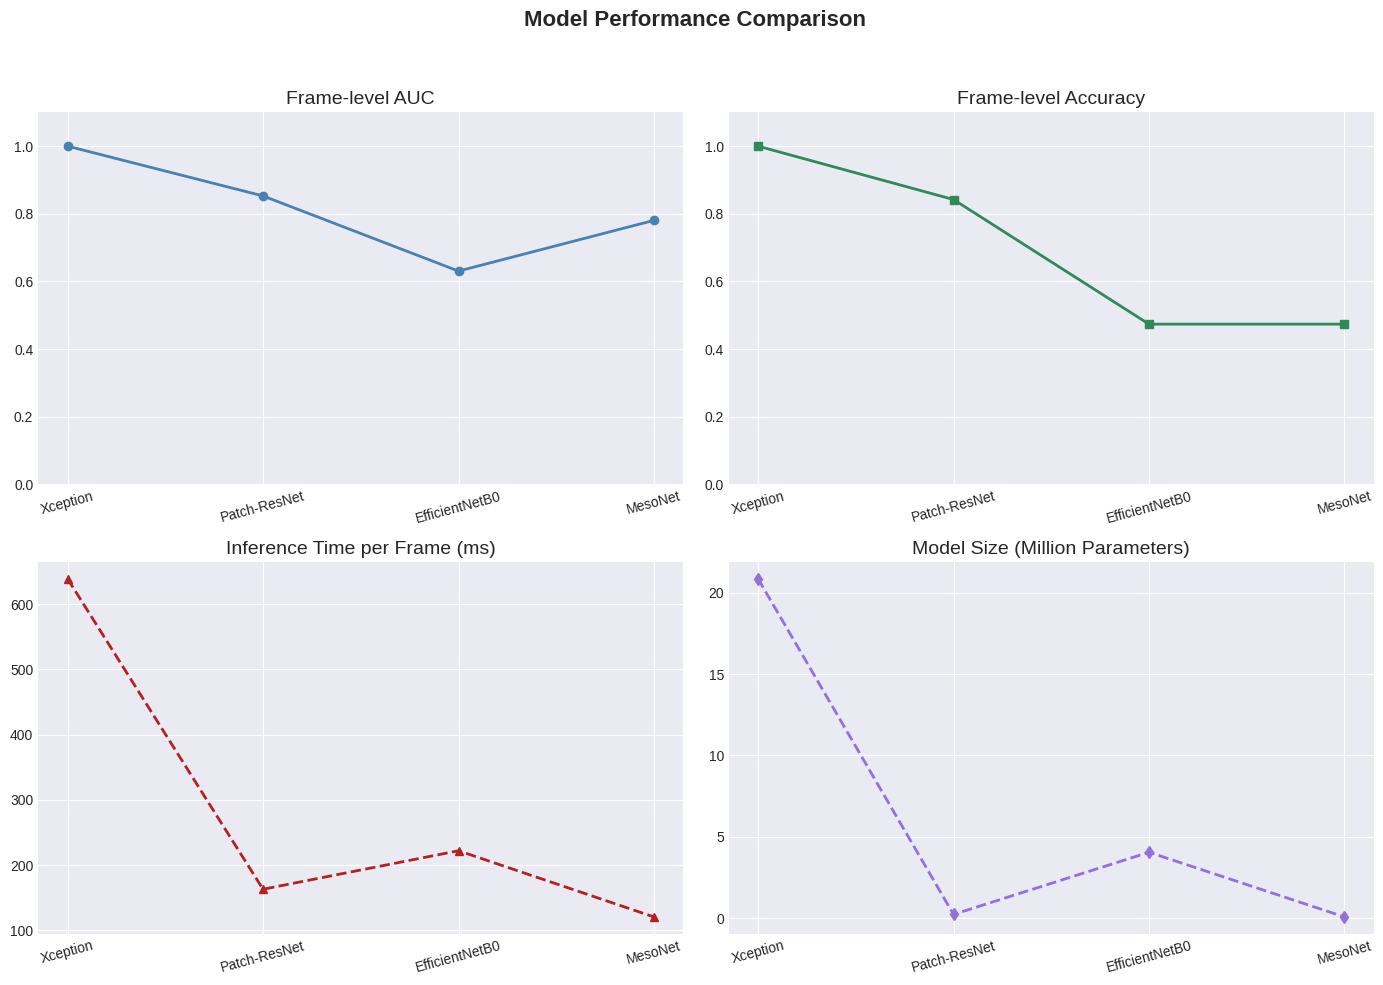

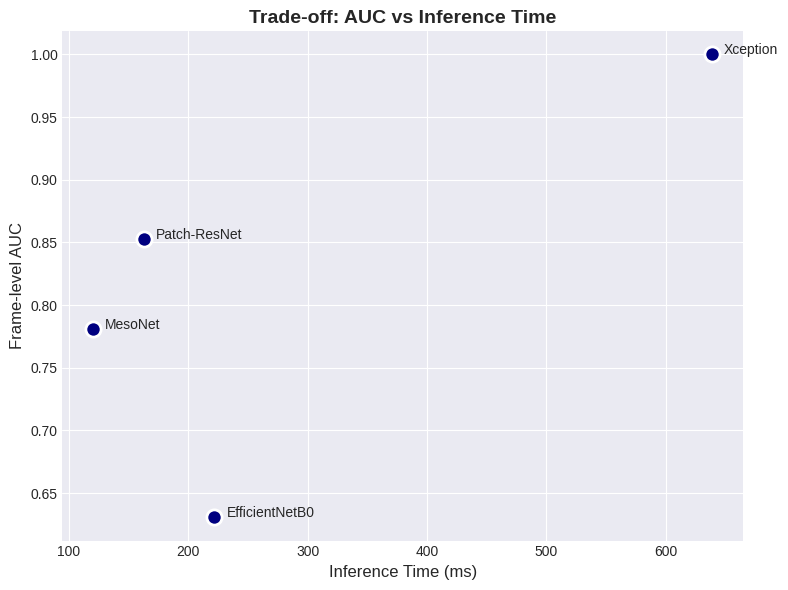

In [6]:
import matplotlib.pyplot as plt

# Model and metric values
model_names = ["Xception", "Patch-ResNet", "EfficientNetB0", "MesoNet"]
frame_auc = [1.0, 0.8528, 0.6306, 0.7806]
accuracy = [1.0, 0.8421, 0.4737, 0.4737]
inference_time = [638.84, 162.89, 221.93, 120.46]  # ms
params = [20.86, 0.23, 4.05, 0.075]  # millions

x = range(len(model_names))

plt.style.use("seaborn-v0_8-darkgrid")  # clean, modern look
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- Line Chart: AUC ---
axes[0, 0].plot(x, frame_auc, marker='o', linestyle='-', color='steelblue', linewidth=2)
axes[0, 0].set_title("Frame-level AUC", fontsize=14)
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(model_names, rotation=15)
axes[0, 0].set_ylim([0, 1.1])

# --- Line Chart: Accuracy ---
axes[0, 1].plot(x, accuracy, marker='s', linestyle='-', color='seagreen', linewidth=2)
axes[0, 1].set_title("Frame-level Accuracy", fontsize=14)
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(model_names, rotation=15)
axes[0, 1].set_ylim([0, 1.1])

# --- Line Chart: Inference Time ---
axes[1, 0].plot(x, inference_time, marker='^', linestyle='--', color='firebrick', linewidth=2)
axes[1, 0].set_title("Inference Time per Frame (ms)", fontsize=14)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(model_names, rotation=15)

# --- Line Chart: Model Size ---
axes[1, 1].plot(x, params, marker='d', linestyle='--', color='mediumpurple', linewidth=2)
axes[1, 1].set_title("Model Size (Million Parameters)", fontsize=14)
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(model_names, rotation=15)

# Format and render
for ax in axes.flat:
    ax.grid(True)
    ax.tick_params(axis='both', labelsize=10)

fig.suptitle("Model Performance Comparison", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- Scatter Plot: AUC vs Inference Time ---
plt.figure(figsize=(8,6))
plt.scatter(inference_time, frame_auc, c='navy', s=120, edgecolors='white', linewidth=2)

for i, name in enumerate(model_names):
    plt.text(inference_time[i] + 10, frame_auc[i], name, fontsize=10)

plt.xlabel("Inference Time (ms)", fontsize=12)
plt.ylabel("Frame-level AUC", fontsize=12)
plt.title("Trade-off: AUC vs Inference Time", fontsize=14, weight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()
